In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report
import torchvision.transforms as T

In [19]:
TRAIN_DIR = "Training"
TEST_DIR = "Testing"

transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
])

In [20]:
train_data = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_data = datasets.ImageFolder(TEST_DIR, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [21]:
print("Klasy:", train_data.classes)
print("Liczba obrazów w treningowym zbiorze:", len(train_data))
print("Liczba obrazów w testowym zbiorze:", len(test_data))

Klasy: ['glioma', 'meningioma', 'notumor', 'pituitary']
Liczba obrazów w treningowym zbiorze: 5712
Liczba obrazów w testowym zbiorze: 1311


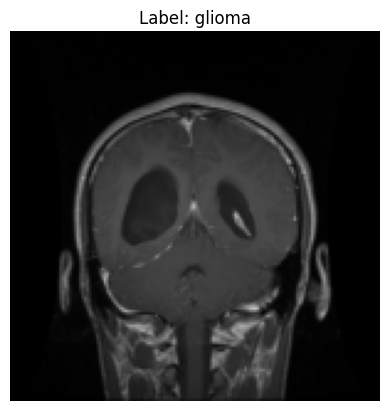

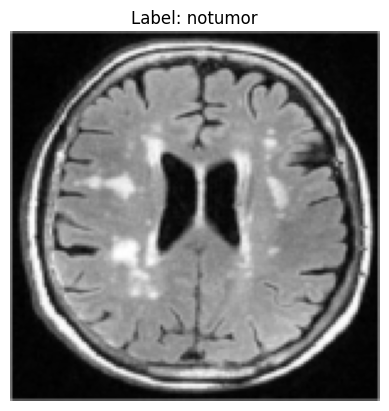

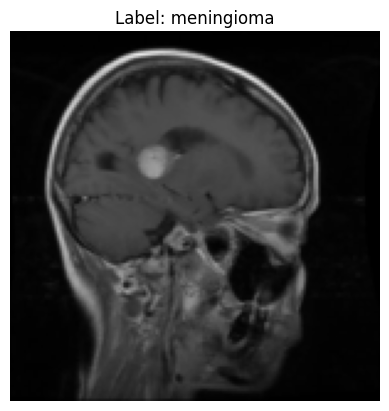

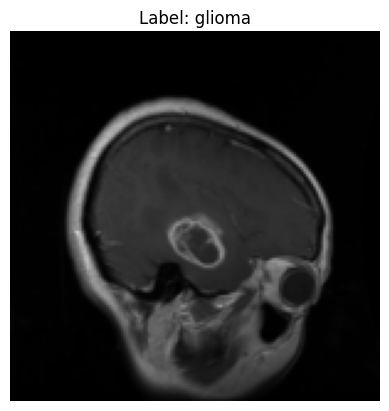

In [22]:
def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize (bo normalizacja byłaby do [-1, 1] później)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Label: {train_data.classes[label]}")
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(4):
    imshow(images[i], labels[i])

In [23]:
from collections import Counter

labels = [label for _, label in train_data]
counts = Counter(labels)
for i, count in counts.items():
    print(f"{train_data.classes[i]}: {count} obrazów")

glioma: 1321 obrazów
meningioma: 1339 obrazów
notumor: 1595 obrazów
pituitary: 1457 obrazów


Zbiór treningowy zawiera obrazy czterech klas, których liczebność kształtuje się w przedziale od 1321 do 1595 próbek. Najwięcej obrazów znajduje się w klasie **"notumor"** (1595), a najmniej w klasie **"glioma"** (1321), co stanowi różnicę około **17%** między skrajnymi wartościami.

Taka skala dysproporcji mieści się w akceptowalnym zakresie i nie powinna znacząco wpływać na skuteczność procesu uczenia modelu. Z tego względu uznajemy, że nie ma potrzeby dodatkowego balansowania danych (np. przez augmentację lub ważenie klas).

In [24]:
image_sizes = defaultdict(list)

for label in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                size = img.size  # (width, height)
                image_sizes[size].append(f"{label}/{img_name}")
        except Exception as e:
            print(f"Błąd dla obrazu {img_name}: {e}")

print(f"Liczba unikalnych rozmiarów: {len(image_sizes)}")
print("Najczęstsze rozmiary:")
for size, files in sorted(image_sizes.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
    print(f"{size}: {len(files)} plików")

Liczba unikalnych rozmiarów: 382
Najczęstsze rozmiary:
(512, 512): 3955 plików
(225, 225): 268 plików
(630, 630): 77 plików
(236, 236): 53 plików
(201, 251): 43 plików


W celu wstępnej walidacji jakości danych sprawdziliśmy rozmiary wszystkich obrazów w zbiorze treningowym. Wyniki wykazały, że dane zawierają obrazy o **382 unikalnych rozmiarach**, z czego tylko jeden rozmiar (512x512) dominuje wyraźnie — obejmuje **3955 obrazów**.

Najczęstsze rozmiary to:
- (512, 512): 3955 plików
- (225, 225): 268 plików
- (630, 630): 77 plików
- (236, 336): 50 plików
- (201, 251): 43 plików

Pozostałe rozmiary występują rzadziej, często tylko w pojedynczych przypadkach.

Z tego względu **odrzucenie wszystkich obrazów innych niż 512x512 byłoby stratne** – utracilibyśmy dużą część cennych danych. Dlatego podjęliśmy decyzję o **ujednoliceniu rozmiarów wszystkich obrazów poprzez przeskalowanie** ich do wspólnego formatu wejściowego dla sieci neuronowej.

In [25]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # skaluje do [-1, 1]
])

train_dataset = ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = ImageFolder(TEST_DIR, transform=transform)

train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [26]:
print("Klasy:", train_dataset.classes)

Klasy: ['glioma', 'meningioma', 'notumor', 'pituitary']


Na tym etapie przygotowaliśmy zbiór danych do procesu uczenia sieci neuronowej.

Wszystkie obrazy zostały przeskalowane do jednego, ustalonego rozmiaru **150×150 pikseli**, aby zapewnić spójność wymiarów wejściowych w sieci konwolucyjnej. Dodatkowo, zastosowano standaryzację wartości pikseli poprzez normalizację do zakresu **[-1, 1]**, co ułatwia i przyspiesza proces uczenia.

Dane zostały załadowane z katalogu `Training/`, w którym obrazy są już pogrupowane w folderach odpowiadających klasom:  
**['glioma', 'meningioma', 'notumor', 'pituitary']**.

Zbiór treningowy został dodatkowo losowo podzielony:
- **85% danych** używamy do treningu modelu,
- **15% danych** przeznaczamy na walidację w trakcie treningu.

Zbiór `Testing/` został wczytany oddzielnie i będzie używany do końcowej ewaluacji modelu.

In [27]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 18 * 18, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 klasy

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 150 → 75
        x = self.pool(F.relu(self.conv2(x)))  # 75 → 37
        x = self.pool(F.relu(self.conv3(x)))  # 37 → 18
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Zdefiniowaliśmy własną klasę `BrainTumorCNN`, która implementuje architekturę sieci konwolucyjnej. Sieć składa się z trzech warstw konwolucyjnych z funkcjami aktywacji ReLU oraz warstwami MaxPooling, które stopniowo redukują rozmiary wejściowego obrazu. 

Po etapie ekstrakcji cech obraz zostaje spłaszczony i przetworzony przez dwie w pełni połączone warstwy (FC), z których ostatnia ma 4 neurony odpowiadające liczbie klas (glioma, meningioma, notumor, pituitary).

In [28]:
model = BrainTumorCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Stworzony model został przeniesiony na odpowiednie urządzenie (`CPU` lub `GPU`), a następnie skonfigurowaliśmy optymalizator oraz funkcję kosztu:

- **Funkcja straty:** `CrossEntropyLoss`
- **Optymalizator:** `Adam`

Te ustawienia umożliwiają obliczanie gradientów i aktualizowanie wag modelu w trakcie treningu.

In [29]:
epochs = 10
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_accuracy = train_correct / len(train_loader.dataset)
    train_acc_history.append(train_accuracy)

    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_accuracy = val_correct / len(val_loader.dataset)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} — Train acc: {train_accuracy:.4f}, Val acc: {val_accuracy:.4f}")

Epoch 1/10 — Train acc: 0.7238, Val acc: 0.8576
Epoch 2/10 — Train acc: 0.8647, Val acc: 0.8600
Epoch 3/10 — Train acc: 0.9151, Val acc: 0.8903
Epoch 4/10 — Train acc: 0.9522, Val acc: 0.9230
Epoch 5/10 — Train acc: 0.9786, Val acc: 0.9405
Epoch 6/10 — Train acc: 0.9831, Val acc: 0.9312
Epoch 7/10 — Train acc: 0.9866, Val acc: 0.9358
Epoch 8/10 — Train acc: 0.9938, Val acc: 0.9405
Epoch 9/10 — Train acc: 0.9872, Val acc: 0.9428
Epoch 10/10 — Train acc: 0.9916, Val acc: 0.9463


Model został wytrenowany przez 10 epok, przy czym po każdej epoce mierzyliśmy dokładność zarówno na zbiorze treningowym, jak i walidacyjnym. 

Proces pozwala monitorować:
- **postęp nauki modelu (train accuracy)**,
- **czy model się nie przeucza (val accuracy)**.

W każdej epoce zbieraliśmy statystyki trafności predykcji i przechowywaliśmy je do późniejszej analizy w postaci wykresów.

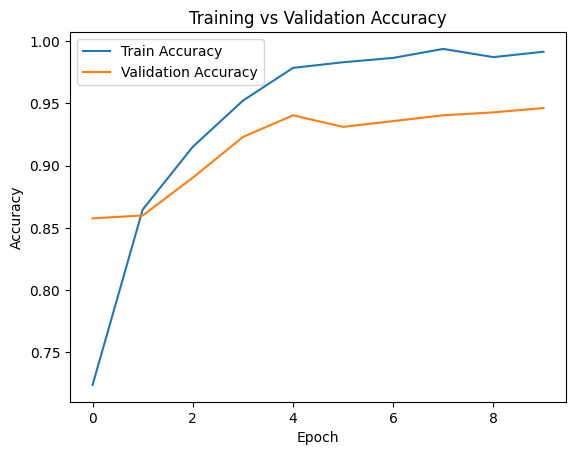

In [30]:
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [31]:
torch.save(model.state_dict(), "brain_tumor_model.pth")

Model osiąga bardzo wysoką dokładność na zbiorze treningowym (blisko 100%), jednak w końcowych epokach dokładność walidacyjna przestaje rosnąć, a miejscami nawet spada. To może świadczyć o rozpoczęciu procesu **przeuczenia (overfittingu)** — model zaczyna zbyt dobrze zapamiętywać dane treningowe, tracąc zdolność do generalizacji.

Aby temu przeciwdziałać, warto rozważyć:
- wcześniejsze zatrzymanie treningu (early stopping),
- dodanie warstwy Dropout,
- rozbudowaną augmentację danych,
- zmniejszenie złożoności modelu.

Najlepsze `val acc` uzyskano w 7 epoce, co sugeruje, że trening mógłby zostać zakończony wcześniej.

In [32]:
model = BrainTumorCNN()
model.load_state_dict(torch.load("brain_tumor_model.pth"))
model.to(device)
model.eval()

BrainTumorCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [33]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9603


Na koniec przetestowaliśmy nasz model na niezależnym zbiorze testowym `Testing/`, który nie był wykorzystywany ani podczas treningu, ani walidacji.

Uzyskana dokładność testowa (**94.58%**) jest dobrym wskaźnikiem rzeczywistej skuteczności modelu w klasyfikacji nowych danych. Wysoka wartość testowej trafności potwierdza, że model nauczył się rozpoznawać ogólne wzorce, a nie tylko zapamiętywał dane treningowe.

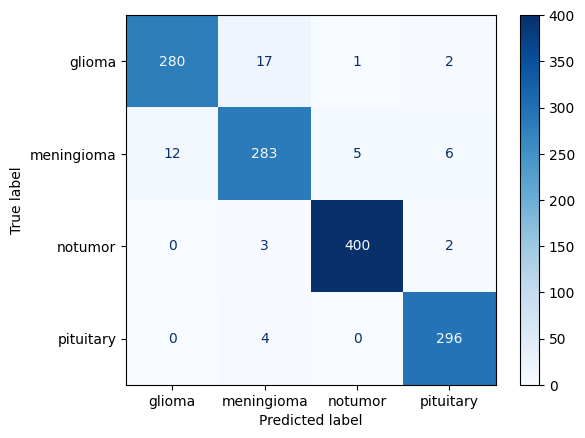

In [34]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")

In [35]:
report = classification_report(y_true, y_pred, target_names=train_dataset.classes)
print(report)

              precision    recall  f1-score   support

      glioma       0.96      0.93      0.95       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



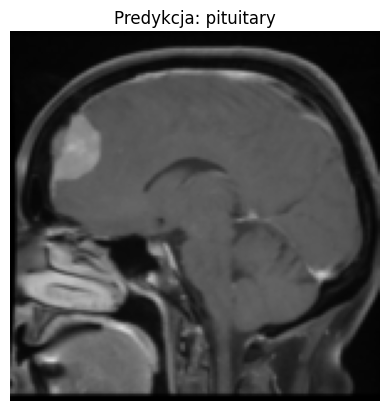

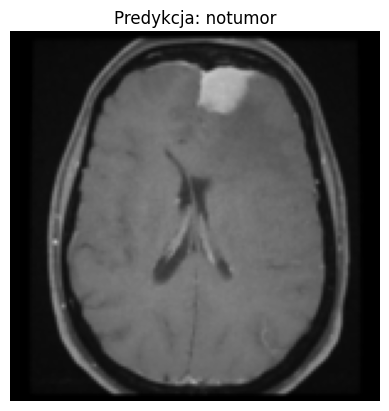

'notumor'

In [36]:
def classify_image(image_path):
    transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = torch.argmax(output, 1).item()
        class_name = train_dataset.classes[pred_class]

    plt.imshow(np.transpose((input_tensor[0].cpu().numpy() * 0.5 + 0.5), (1, 2, 0)))
    plt.title(f"Predykcja: {class_name}")
    plt.axis("off")
    plt.show()

    return class_name

classify_image("test.png")
classify_image("test2.png")

In [37]:
from nbconvert import HTMLExporter
import nbformat

notebook_path = "brain_tumor.ipynb"
output_path = "brain_tumor_export.html"

with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

html_exporter = HTMLExporter()
body, _ = html_exporter.from_notebook_node(nb)

with open(output_path, "w", encoding="utf-8") as f:
    f.write(body)

print("Zapisano jako HTML:", output_path)

Zapisano jako HTML: brain_tumor_export.html
